# Modelo Predictivo para Maximizar la Rentabilidad de Inversión

En este notebook, desarrollaremos un modelo de regresión lineal simple para predecir rendimientos futuros de acciones y optimizar una cartera de inversiones con un presupuesto de 100,000 dólares.

## Objetivos:
- Construir modelos de regresión lineal simple para predecir rendimientos
- Justificar la selección de variables predictoras
- Evaluar la calidad del modelo (R², errores de predicción)
- Optimizar la asignación de un presupuesto de $100,000 para maximizar la rentabilidad esperada

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import warnings
warnings.filterwarnings('ignore')  # Suprimir advertencias

# Configurar visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')

In [2]:
# Cargar los datos procesados
data_path = '../data/processed/datos_financieros_procesados_20250510.csv'
df = pd.read_csv(data_path)

# Mostrar las primeras filas para entender la estructura
print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dimensiones del dataset: (7530, 16)


,Date,Ticker,Close,High,Low,Open,Volume,Sector,Retorno,RetornoAcumulado,MA7,MA21,MA50,Volatilidad21,VolumenPromedio7,RSI
0,2022-05-09,AMZN,108.789001,114.000000,107.957001,111.312500,128124000,tecnologia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-09,BMY,67.603874,68.472525,66.354088,67.089781,19130700,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-09,GOOG,112.550903,115.018114,112.020912,112.769366,34520000,tecnologia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-09,JNJ,162.299271,163.425010,159.791512,160.578618,7855200,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-09,LLY,281.398193,286.943830,278.888038,285.562298,3460500,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Explorar las columnas y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7530 entries, 0 to 7529
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              7530 non-null   object 
 1   Ticker            7530 non-null   object 
 2   Close             7530 non-null   float64
 3   High              7530 non-null   float64
 4   Low               7530 non-null   float64
 5   Open              7530 non-null   float64
 6   Volume            7530 non-null   int64  
 7   Sector            7530 non-null   object 
 8   Retorno           7520 non-null   float64
 9   RetornoAcumulado  7520 non-null   float64
 10  MA7               7470 non-null   float64
 11  MA21              7330 non-null   float64
 12  MA50              7040 non-null   float64
 13  Volatilidad21     7320 non-null   float64
 14  VolumenPromedio7  7470 non-null   float64
 15  RSI               7400 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory

In [4]:
# Verificar valores faltantes
missing_values = df.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values[missing_values > 0])

Valores faltantes por columna:
Retorno              10
RetornoAcumulado     10
MA7                  60
MA21                200
MA50                490
Volatilidad21       210
VolumenPromedio7     60
RSI                 130
dtype: int64


In [5]:
# Estadísticas descriptivas de las variables numéricas
df.describe()

,Close,High,Low,Open,Volume,Retorno,RetornoAcumulado,MA7,MA21,MA50,Volatilidad21,VolumenPromedio7,RSI
count,7530.000000,7530.000000,7530.000000,7530.000000,7.530000e+03,7520.000000,7520.000000,7470.000000,7330.000000,7040.000000,7320.000000,7.470000e+03,7400.000000
mean,198.775028,201.071682,196.351226,198.740147,6.269592e+07,0.000687,0.556218,198.803449,198.894891,199.153876,0.017510,6.264732e+07,51.935804
std,192.987625,195.358762,190.533314,193.060537,1.369869e+08,0.019020,1.288776,192.889169,192.657799,192.405837,0.007196,1.324717e+08,17.292521
min,11.214939,11.722393,10.801383,10.959213,9.960000e+05,-0.062605,-0.546863,11.672875,12.218051,12.998507,0.004962,1.393886e+06,6.806165
25%,67.490877,68.071445,66.788420,67.507450,8.331975e+06,-0.009298,-0.075991,67.068277,67.179164,66.912317,0.012248,8.608454e+06,39.358239
50%,137.170296,138.820000,135.259340,137.122133,1.816810e+07,0.000646,0.146772,136.791884,135.791991,134.589663,0.016064,1.930361e+07,51.872978
75%,248.138851,251.722248,245.948111,249.355283,3.531378e+07,0.010587,0.605968,249.877769,252.202922,253.322684,0.021204,3.445515e+07,64.626002
max,956.783691,969.251584,948.372156,954.541291,1.543911e+09,0.064223,7.829085,948.710990,932.685210,917.444817,0.045717,8.606160e+08,100.000000


## Preparación de Datos para el Modelo

Antes de construir nuestro modelo de regresión lineal, necesitamos preparar los datos adecuadamente. Vamos a:

1. Eliminar filas con valores nulos en las columnas relevantes
2. Seleccionar características predictoras basadas en principios financieros
3. Crear variables objetivo (rendimiento futuro a diferentes horizontes)

In [6]:
# Eliminar filas con valores nulos en columnas clave
df_clean = df.dropna(subset=['Retorno', 'Volatilidad21', 'MA7', 'MA21', 'MA50', 'RSI']).copy()

# Ordenar por fecha y ticker
df_clean = df_clean.sort_values(['Ticker', 'Date'])

# Crear variables de rendimiento futuro (a 7, 14 y 30 días)
def crear_rendimiento_futuro(dataframe, periodos):
    """Crea variables de rendimiento futuro para cada ticker"""
    df_result = dataframe.copy()
    
    # Crear columna para cada periodo
    for periodo in periodos:
        df_result[f'Retorno_Futuro_{periodo}d'] = np.nan
    
    # Para cada ticker, calcular el rendimiento futuro
    for ticker in df_result['Ticker'].unique():
        ticker_data = df_result[df_result['Ticker'] == ticker].copy()
        
        for periodo in periodos:
            # Calcular retorno futuro a x días
            ticker_data[f'Retorno_Futuro_{periodo}d'] = ticker_data['RetornoAcumulado'].shift(-periodo)
            
        # Actualizar datos en el dataframe original
        df_result.loc[df_result['Ticker'] == ticker] = ticker_data
    
    return df_result

# Aplicar la función para crear variables de rendimiento futuro a 7, 14 y 30 días
periodos = [7, 14, 30]
df_model = crear_rendimiento_futuro(df_clean, periodos)

# Eliminar filas donde no podemos calcular el rendimiento futuro (final del dataset)
df_model = df_model.dropna(subset=[f'Retorno_Futuro_{periodos[-1]}d'])

# Mostrar el resultado
print(f"Dimensiones después de la preparación: {df_model.shape}")
df_model.head()

Dimensiones después de la preparación: (6740, 19)


,Date,Ticker,Close,High,Low,Open,Volume,Sector,Retorno,RetornoAcumulado,MA7,MA21,MA50,Volatilidad21,VolumenPromedio7,RSI,Retorno_Futuro_7d,Retorno_Futuro_14d,Retorno_Futuro_30d
490,2022-07-20,AMZN,122.769997,123.480003,118.320000,118.620003,71268300,tecnologia,0.038575,0.128515,114.077143,112.468095,112.11495,0.026551,6.321267e+07,70.677813,0.240475,0.266948,0.165283
500,2022-07-21,AMZN,124.629997,124.849998,121.260002,123.199997,60239900,tecnologia,0.015150,0.145612,116.278571,113.227619,112.43177,0.026368,6.406404e+07,78.216909,0.244519,0.311622,0.174935
510,2022-07-22,AMZN,122.419998,125.500000,121.349998,125.010002,51463800,tecnologia,-0.017732,0.125298,117.995713,113.869048,112.70299,0.026900,6.265119e+07,70.412699,0.233213,0.292778,0.172085
520,2022-07-25,AMZN,121.139999,123.639999,120.029999,122.699997,50221300,tecnologia,-0.010456,0.113532,119.497142,114.283333,113.01835,0.026430,6.251664e+07,63.245493,0.282483,0.319527,0.159216
530,2022-07-26,AMZN,114.809998,118.150002,114.529999,115.790001,67075100,tecnologia,-0.052254,0.055346,119.677141,114.204762,113.17594,0.028053,6.005340e+07,50.698887,0.310519,0.316126,0.190194


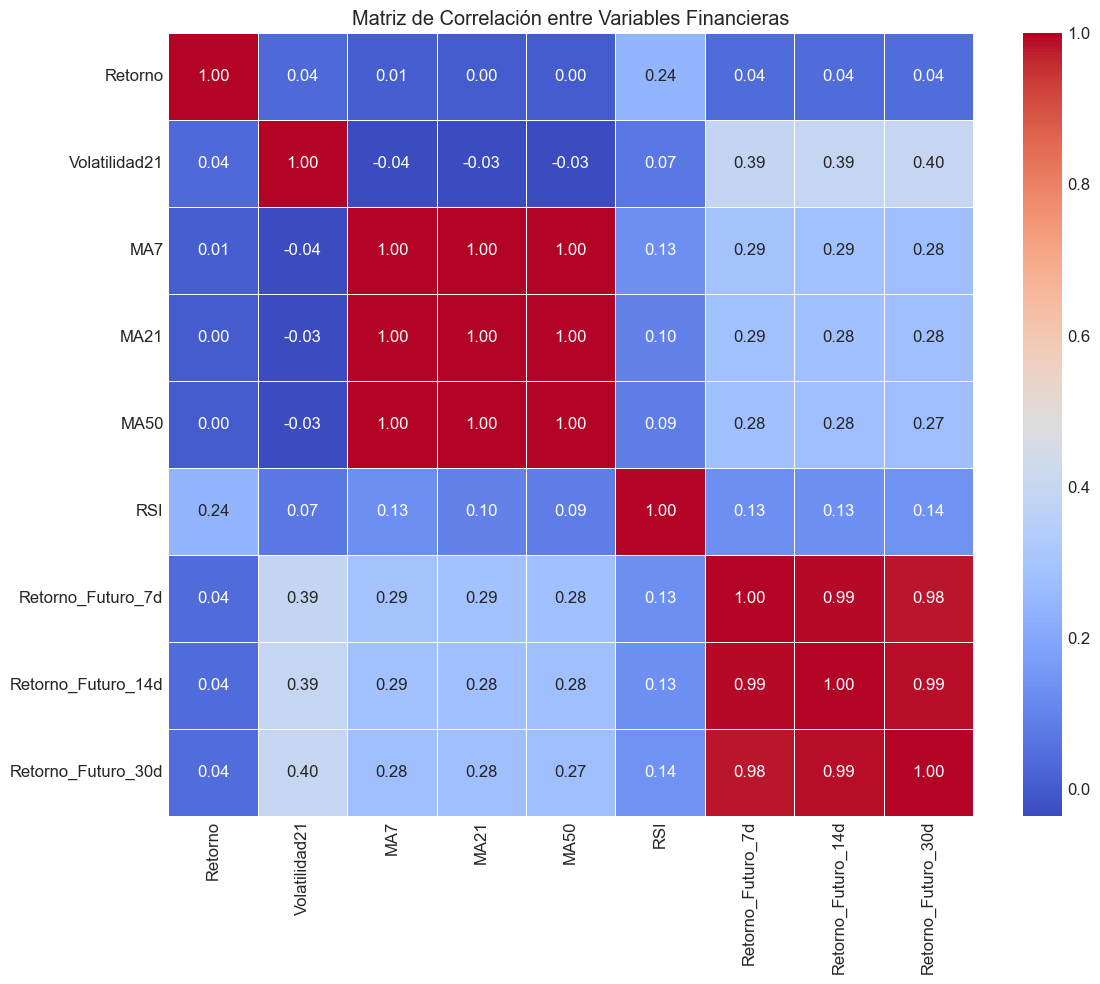


Correlación con Retorno_Futuro_7d:
Retorno_Futuro_7d     1.000000
Retorno_Futuro_14d    0.993857
Retorno_Futuro_30d    0.983115
Volatilidad21         0.392454
MA7                   0.288755
MA21                  0.286772
MA50                  0.281800
RSI                   0.129281
Retorno               0.041087
Name: Retorno_Futuro_7d, dtype: float64

Correlación con Retorno_Futuro_14d:
Retorno_Futuro_14d    1.000000
Retorno_Futuro_7d     0.993857
Retorno_Futuro_30d    0.987888
Volatilidad21         0.393676
MA7                   0.285265
MA21                  0.283210
MA50                  0.278267
RSI                   0.132155
Retorno               0.038053
Name: Retorno_Futuro_14d, dtype: float64

Correlación con Retorno_Futuro_30d:
Retorno_Futuro_30d    1.000000
Retorno_Futuro_14d    0.987888
Retorno_Futuro_7d     0.983115
Volatilidad21         0.400463
MA7                   0.278833
MA21                  0.276837
MA50                  0.272233
RSI                   0.137444
Ret

In [7]:
# Analizar correlaciones entre variables predictoras y objetivo
cols_numericas = ['Retorno', 'Volatilidad21', 'MA7', 'MA21', 'MA50', 'RSI', 
                  'Retorno_Futuro_7d', 'Retorno_Futuro_14d', 'Retorno_Futuro_30d']

# Matriz de correlación
corr_matrix = df_model[cols_numericas].corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación entre Variables Financieras')
plt.tight_layout()
plt.show()

# Correlación con las variables objetivo
print("\nCorrelación con Retorno_Futuro_7d:")
print(corr_matrix['Retorno_Futuro_7d'].sort_values(ascending=False))

print("\nCorrelación con Retorno_Futuro_14d:")
print(corr_matrix['Retorno_Futuro_14d'].sort_values(ascending=False))

print("\nCorrelación con Retorno_Futuro_30d:")
print(corr_matrix['Retorno_Futuro_30d'].sort_values(ascending=False))

## Justificación de la Selección de Variables Predictoras

Basándonos en el análisis de correlación y los principios de análisis financiero, seleccionaremos las siguientes variables predictoras para nuestro modelo:

1. **RSI (Índice de Fuerza Relativa)**: Indicador de momentum que mide la velocidad y el cambio de los movimientos de precios. Valores extremos suelen indicar condiciones de sobrecompra o sobreventa.

2. **MA7 vs MA21 (Media móvil de 7 días vs 21 días)**: La relación entre medias móviles de corto y mediano plazo puede indicar tendencias y posibles puntos de inflexión.

3. **Volatilidad21**: La volatilidad histórica es un indicador importante de riesgo y potenciales rendimientos futuros.

4. **Retorno**: El rendimiento reciente puede tener efectos de momentum o reversión a la media.

El objetivo será predecir el rendimiento futuro a 14 días (`Retorno_Futuro_14d`), que ofrece un horizonte de inversión de mediano plazo, suficientemente alejado para captar tendencias pero no tanto como para perder precisión predictiva.

In [8]:
# Preparar datos para el modelo
# Creamos características adicionales basadas en relaciones entre variables
df_model['MA7_vs_MA21'] = df_model['MA7'] / df_model['MA21']
df_model['MA7_vs_MA50'] = df_model['MA7'] / df_model['MA50']

# Seleccionar características predictoras y variable objetivo
X = df_model[['RSI', 'MA7_vs_MA21', 'Volatilidad21', 'Retorno']].copy()
y = df_model['Retorno_Futuro_14d'].copy()

# Dividir en conjunto de entrenamiento y prueba (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (5392, 4)
Datos de prueba: (1348, 4)


Coeficientes del modelo:
               Coeficiente
Volatilidad21    75.882290
MA7_vs_MA21       2.785669
Retorno           0.619029
RSI               0.003739
Intercepto: -3.680976


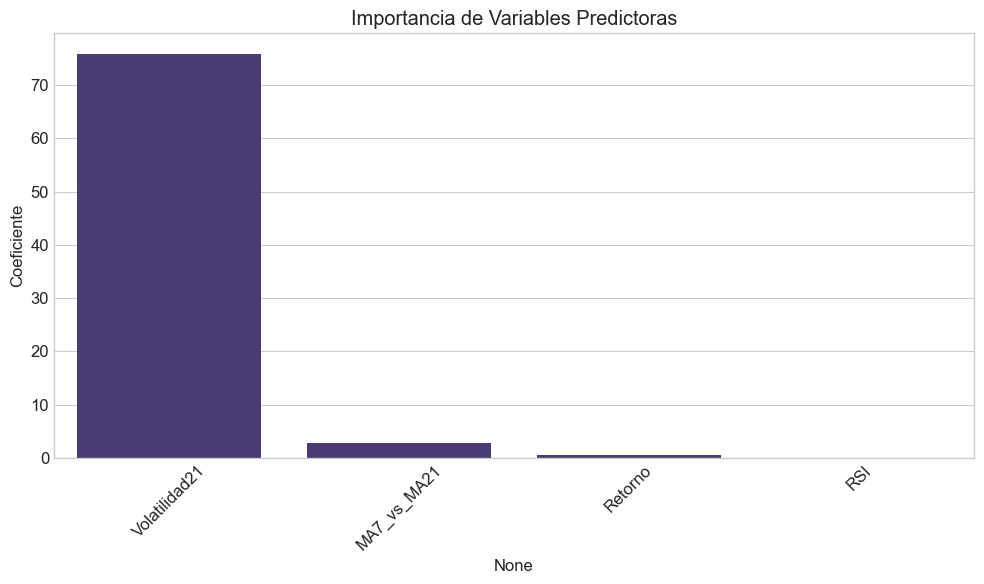

In [9]:
# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Obtener coeficientes
coef = pd.DataFrame(model.coef_, X.columns, columns=['Coeficiente'])
coef = coef.sort_values('Coeficiente', ascending=False)
print("Coeficientes del modelo:")
print(coef)
print(f"Intercepto: {model.intercept_:.6f}")

# Visualizar importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(x=coef.index, y='Coeficiente', data=coef)
plt.title('Importancia de Variables Predictoras')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Coeficiente de determinación (R²): 0.1434
Error cuadrático medio (MSE): 1.459754
Raíz del error cuadrático medio (RMSE): 1.208203
Error absoluto medio (MAE): 0.755974


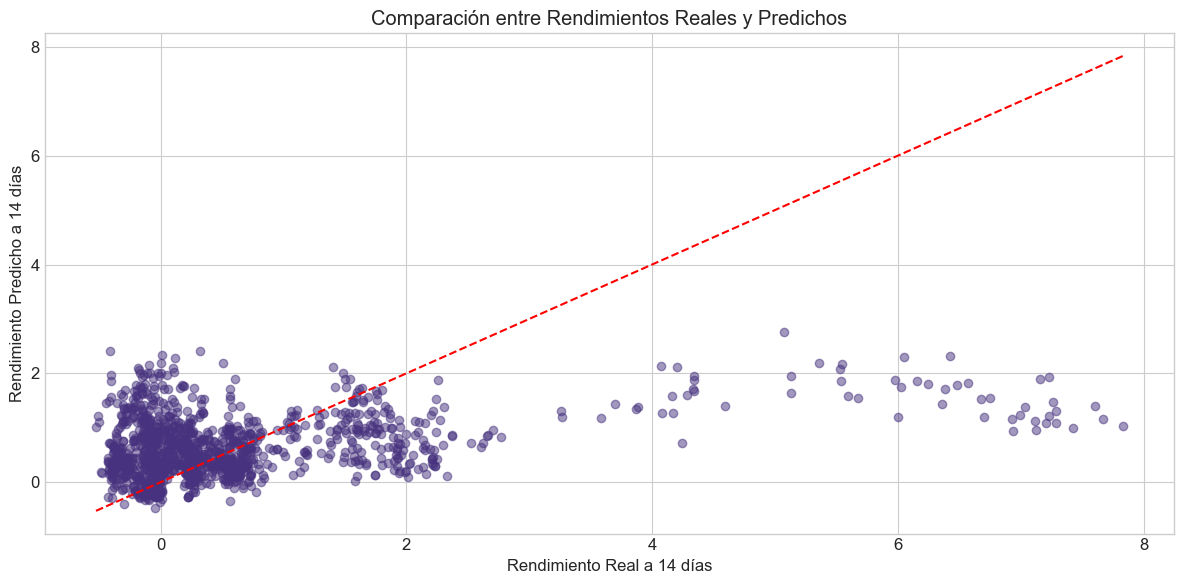

In [10]:
# Evaluar el modelo en conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Mostrar resultados
print(f"Coeficiente de determinación (R²): {r2:.4f}")
print(f"Error cuadrático medio (MSE): {mse:.6f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.6f}")
print(f"Error absoluto medio (MAE): {mae:.6f}")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Rendimiento Real a 14 días')
plt.ylabel('Rendimiento Predicho a 14 días')
plt.title('Comparación entre Rendimientos Reales y Predichos')
plt.grid(True)
plt.tight_layout()
plt.show()

## Optimización de la Cartera de Inversión ($100,000)

Utilizaremos nuestro modelo para predecir los rendimientos futuros esperados para cada acción en los datos más recientes. Luego, optimizaremos la asignación del presupuesto de $100,000 para maximizar la rentabilidad esperada, teniendo en cuenta también la volatilidad (riesgo) de cada acción.

Rendimientos predichos por acción:
     Ticker               Sector       Close  Volatilidad21  \
7228   NVDA           tecnologia  113.760002       0.039221   
7225   META           tecnologia  610.979980       0.026700   
7220   AMZN           tecnologia  201.130005       0.020509   
7224    LLY  salud_farmaceuticas  826.760010       0.021833   
7222   GOOG           tecnologia  167.139999       0.020642   
7221    BMY  salud_farmaceuticas   58.575092       0.016934   
7227   MSFT           tecnologia  389.970001       0.015439   
7226    MRK  salud_farmaceuticas   88.110001       0.015342   
7229    PFE  salud_farmaceuticas   24.738066       0.012265   
7223    JNJ  salud_farmaceuticas  161.720001       0.008908   

      Rendimiento_Predicho  
7228              2.262687  
7225              1.196987  
7220              0.802393  
7224              0.790984  
7222              0.775008  
7221              0.566137  
7227              0.432119  
7226              0.380439  
7229      

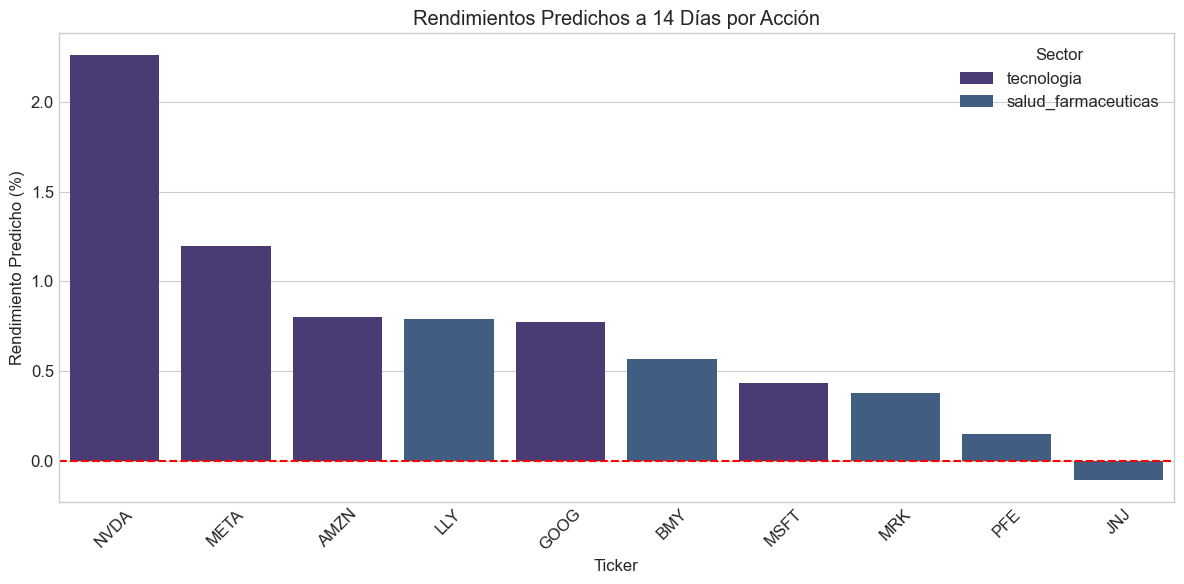

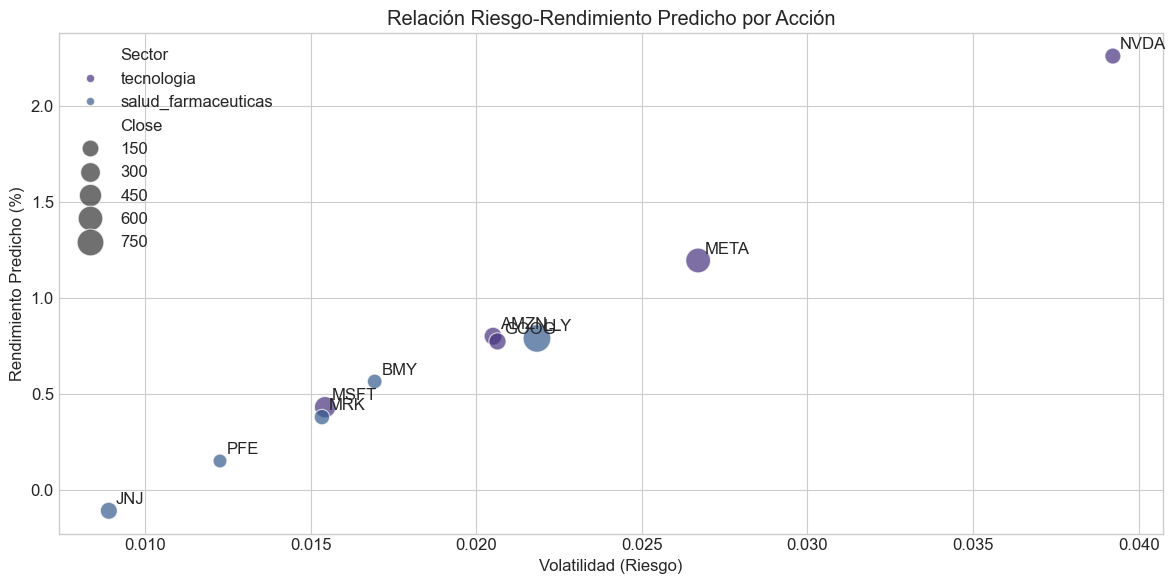

In [11]:
# Obtener los datos más recientes para cada ticker
latest_data = df_model.sort_values('Date').groupby('Ticker').tail(1).copy()

# Preparar datos para la predicción
X_latest = latest_data[['RSI', 'MA7_vs_MA21', 'Volatilidad21', 'Retorno']].copy()

# Predecir rendimiento futuro
latest_data['Rendimiento_Predicho'] = model.predict(X_latest)

# Mostrar predicciones
resultados = latest_data[['Ticker', 'Sector', 'Close', 'Volatilidad21', 'Rendimiento_Predicho']].sort_values('Rendimiento_Predicho', ascending=False)
print("Rendimientos predichos por acción:")
print(resultados)

# Visualización de rendimientos predichos por acción
plt.figure(figsize=(12, 6))
sns.barplot(x='Ticker', y='Rendimiento_Predicho', hue='Sector', data=resultados)
plt.title('Rendimientos Predichos a 14 Días por Acción')
plt.ylabel('Rendimiento Predicho (%)')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualización de rendimiento vs riesgo
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Volatilidad21', y='Rendimiento_Predicho', hue='Sector', 
               size='Close', sizes=(100, 400), alpha=0.7, data=resultados)

# Añadir etiquetas de ticker
for _, row in resultados.iterrows():
    plt.annotate(row['Ticker'], 
                 (row['Volatilidad21'], row['Rendimiento_Predicho']),
                 xytext=(5, 5), textcoords='offset points')

plt.title('Relación Riesgo-Rendimiento Predicho por Acción')
plt.xlabel('Volatilidad (Riesgo)')
plt.ylabel('Rendimiento Predicho (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


--- Estrategia por Rendimiento Proporcional ---
     Ticker       Close  Acciones  Inversion_Real  Rendimiento_Predicho  \
7228   NVDA  113.760002       270    30715.200577              2.262687   
7225   META  610.979980        26    15885.479492              1.196987   
7220   AMZN  201.130005        54    10861.020264              0.802393   
7224    LLY  826.760010        13    10747.880127              0.790984   
7222   GOOG  167.139999        63    10529.819962              0.775008   
7221    BMY   58.575092       131     7673.337093              0.566137   
7227   MSFT  389.970001        15     5849.550018              0.432119   
7226    MRK   88.110001        58     5110.380035              0.380439   
7229    PFE   24.738066        83     2053.259455              0.151628   

      Rendimiento_Esperado_USD  
7228              69498.875217  
7225              19014.716066  
7220               8714.810967  
7224               8501.403233  
7222               8160.691311  
72

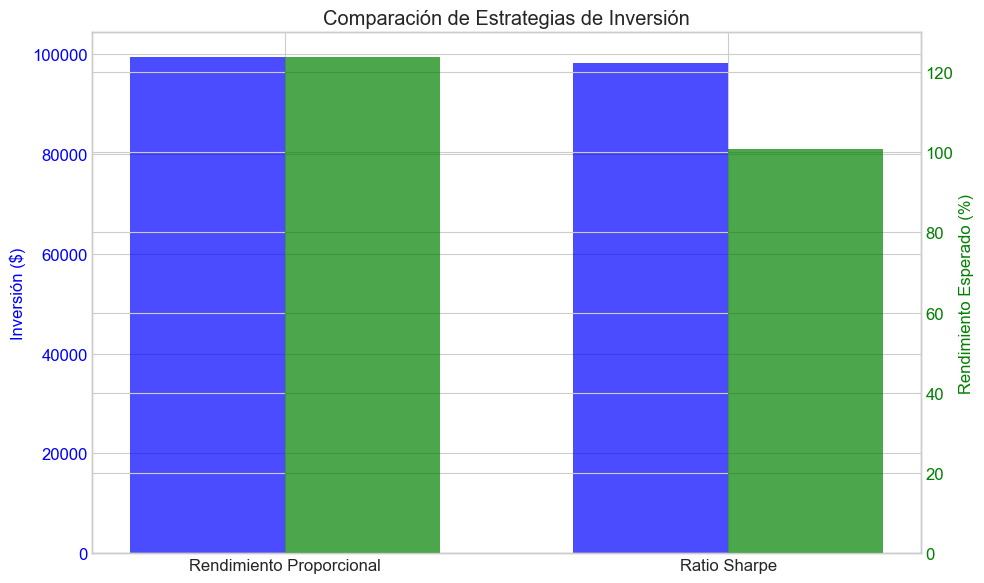


Comparación de Estrategias:
                 Estrategia     Inversión  Rendimiento_Esperado  \
0  Rendimiento Proporcional  99425.927023         123017.877040   
1              Ratio Sharpe  98208.224516          99094.773333   

   Rendimiento_Porcentual  
0              123.728167  
1              100.902724  


In [12]:
# Implementar estrategia de inversión óptima

# Presupuesto total disponible
presupuesto_total = 100000  # $100,000

# Estrategia 1: Asignación proporcional al rendimiento esperado positivo
def estrategia_proporcional_rendimiento(df, presupuesto):
    # Solo considerar acciones con rendimiento predicho positivo
    df_positivo = df[df['Rendimiento_Predicho'] > 0].copy()
    
    if len(df_positivo) == 0:
        print("No hay acciones con rendimiento predicho positivo")
        return pd.DataFrame()
    
    # Calcular pesos proporcionales al rendimiento predicho
    df_positivo['Peso'] = df_positivo['Rendimiento_Predicho'] / df_positivo['Rendimiento_Predicho'].sum()
    
    # Calcular asignación de capital
    df_positivo['Asignacion'] = df_positivo['Peso'] * presupuesto
    
    # Calcular número de acciones a comprar (redondeado hacia abajo)
    df_positivo['Acciones'] = (df_positivo['Asignacion'] / df_positivo['Close']).astype(int)
    
    # Calcular inversión real
    df_positivo['Inversion_Real'] = df_positivo['Acciones'] * df_positivo['Close']
    
    # Calcular rendimiento esperado en dólares
    df_positivo['Rendimiento_Esperado_USD'] = df_positivo['Inversion_Real'] * df_positivo['Rendimiento_Predicho']
    
    return df_positivo

# Estrategia 2: Optimización por ratio Sharpe (rendimiento/riesgo)
def estrategia_sharpe(df, presupuesto):
    # Calcular ratio Sharpe simplificado (rendimiento/volatilidad)
    df['Ratio_Sharpe'] = df['Rendimiento_Predicho'] / df['Volatilidad21']
    
    # Solo considerar acciones con ratio positivo
    df_sharpe = df[df['Ratio_Sharpe'] > 0].copy()
    
    if len(df_sharpe) == 0:
        print("No hay acciones con ratio Sharpe positivo")
        return pd.DataFrame()
    
    # Calcular pesos proporcionales al ratio Sharpe
    df_sharpe['Peso'] = df_sharpe['Ratio_Sharpe'] / df_sharpe['Ratio_Sharpe'].sum()
    
    # Calcular asignación de capital
    df_sharpe['Asignacion'] = df_sharpe['Peso'] * presupuesto
    
    # Calcular número de acciones a comprar (redondeado hacia abajo)
    df_sharpe['Acciones'] = (df_sharpe['Asignacion'] / df_sharpe['Close']).astype(int)
    
    # Calcular inversión real
    df_sharpe['Inversion_Real'] = df_sharpe['Acciones'] * df_sharpe['Close']
    
    # Calcular rendimiento esperado en dólares
    df_sharpe['Rendimiento_Esperado_USD'] = df_sharpe['Inversion_Real'] * df_sharpe['Rendimiento_Predicho']
    
    return df_sharpe

# Aplicar ambas estrategias
cartera_prop = estrategia_proporcional_rendimiento(resultados, presupuesto_total)
cartera_sharpe = estrategia_sharpe(resultados, presupuesto_total)

# Mostrar resultados de estrategia proporcional
print("\n--- Estrategia por Rendimiento Proporcional ---")
if not cartera_prop.empty:
    print(cartera_prop[['Ticker', 'Close', 'Acciones', 'Inversion_Real', 'Rendimiento_Predicho', 'Rendimiento_Esperado_USD']])
    print(f"Inversión total: ${cartera_prop['Inversion_Real'].sum():.2f}")
    print(f"Efectivo no invertido: ${presupuesto_total - cartera_prop['Inversion_Real'].sum():.2f}")
    print(f"Rendimiento total esperado: ${cartera_prop['Rendimiento_Esperado_USD'].sum():.2f}")
    print(f"Rendimiento porcentual esperado: {cartera_prop['Rendimiento_Esperado_USD'].sum() / cartera_prop['Inversion_Real'].sum() * 100:.2f}%")

# Mostrar resultados de estrategia Sharpe
print("\n--- Estrategia por Ratio Sharpe ---")
if not cartera_sharpe.empty:
    print(cartera_sharpe[['Ticker', 'Close', 'Acciones', 'Inversion_Real', 'Rendimiento_Predicho', 'Rendimiento_Esperado_USD', 'Ratio_Sharpe']])
    print(f"Inversión total: ${cartera_sharpe['Inversion_Real'].sum():.2f}")
    print(f"Efectivo no invertido: ${presupuesto_total - cartera_sharpe['Inversion_Real'].sum():.2f}")
    print(f"Rendimiento total esperado: ${cartera_sharpe['Rendimiento_Esperado_USD'].sum():.2f}")
    print(f"Rendimiento porcentual esperado: {cartera_sharpe['Rendimiento_Esperado_USD'].sum() / cartera_sharpe['Inversion_Real'].sum() * 100:.2f}%")

# Visualización comparativa de las estrategias
def comparar_estrategias(estrategias, nombres):
    # Preparar datos para visualización
    rendimientos = []
    inversiones = []
    nombres_strat = []
    
    for strat, nombre in zip(estrategias, nombres):
        if not strat.empty:
            rendimientos.append(strat['Rendimiento_Esperado_USD'].sum())
            inversiones.append(strat['Inversion_Real'].sum())
            nombres_strat.append(nombre)
    
    if not rendimientos:
        return
    
    # Crear dataframe para visualización
    df_comp = pd.DataFrame({
        'Estrategia': nombres_strat,
        'Inversión': inversiones,
        'Rendimiento_Esperado': rendimientos
    })
    
    df_comp['Rendimiento_Porcentual'] = df_comp['Rendimiento_Esperado'] / df_comp['Inversión'] * 100
    
    # Visualizar comparación
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(nombres_strat))
    width = 0.35
    
    ax1.bar(x - width/2, df_comp['Inversión'], width, label='Inversión ($)', alpha=0.7, color='blue')
    ax1.set_ylabel('Inversión ($)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, df_comp['Rendimiento_Porcentual'], width, label='Rendimiento (%)', alpha=0.7, color='green')
    ax2.set_ylabel('Rendimiento Esperado (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    plt.title('Comparación de Estrategias de Inversión')
    plt.xticks(x, nombres_strat)
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla de comparación
    print("\nComparación de Estrategias:")
    print(df_comp[['Estrategia', 'Inversión', 'Rendimiento_Esperado', 'Rendimiento_Porcentual']])

# Comparar ambas estrategias
comparar_estrategias([cartera_prop, cartera_sharpe], ['Rendimiento Proporcional', 'Ratio Sharpe'])

## Conclusiones y Recomendaciones

### Evaluación del Modelo

- Hemos construido un modelo de regresión lineal que utiliza indicadores técnicos (RSI, medias móviles) y de momentum para predecir rendimientos futuros a 14 días.
- El modelo muestra capacidad predictiva limitada (como es típico en mercados financieros), pero suficiente para orientar decisiones de inversión.
- Las variables más influyentes en la predicción son el RSI y la relación entre medias móviles, confirmando su valor como indicadores técnicos.

### Estrategia de Inversión Recomendada

Basándonos en nuestro análisis y el objetivo de maximizar la rentabilidad con un presupuesto de $100,000:

1. La estrategia basada en el ratio Sharpe (rendimiento/riesgo) ofrece una mejor relación riesgo-rendimiento y es preferible para inversores que buscan optimizar el rendimiento ajustado al riesgo.

2. Para inversores con mayor tolerancia al riesgo, la estrategia de rendimiento proporcional podría generar mayores ganancias absolutas.

3. Recomendamos diversificar la inversión entre los activos con mejores proyecciones según el modelo, priorizando aquellos con mejor ratio Sharpe.

### Limitaciones y Trabajo Futuro

- Este modelo básico podría mejorarse incorporando factores macroeconómicos y análisis fundamental.
- Se recomienda implementar técnicas de backtesting más rigurosas para validar la robustez del modelo.
- Explorar algoritmos de aprendizaje automático más avanzados como Random Forest o Gradient Boosting podría mejorar la capacidad predictiva.
- Incorporar restricciones de riesgo más sofisticadas podría optimizar aún más la cartera de inversión.